# Imports

In [3219]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV, RFE
import xgboost

from skopt import BayesSearchCV
from skopt.plots import plot_objective
from skopt.space import Real, Categorical, Integer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import make_scorer
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


# Settings

In [3220]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)


# Read data

In [3221]:
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

# Adding building ID

In [3222]:
train_a['building_id'] = 'a'
train_b['building_id'] = 'b'
train_c['building_id'] = 'c'

X_train_estimated_a['building_id'] = 'a'
X_train_estimated_b['building_id'] = 'b'
X_train_estimated_c['building_id'] = 'c'

X_train_observed_a['building_id'] = 'a'
X_train_observed_b['building_id'] = 'b'
X_train_observed_c['building_id'] = 'c'

X_test_estimated_a['building_id'] = 'a'
X_test_estimated_b['building_id'] = 'b'
X_test_estimated_c['building_id'] = 'c'

# Combine data

In [3223]:
def reduce_df(df, group_by='building_id', date_col='date_forecast'):
    #minute = df['date_forecast'].dt.minute
    hourDayMonthYear = df[date_col].dt.floor('H')
    

    df_new = df.groupby([group_by, date_col]).any().reset_index() #just use any aggregations function --> will be overwrittern anyway

    for row_idx in df_new.index:
        if row_idx % 10 == 0:
            print(row_idx)
        building_id = df_new.loc[row_idx, 'building_id']
        hourDayMonthYear = df_new.loc[row_idx, date_col].floor('H')

        row_0  = df.loc[(df['building_id'] == building_id) & (df[date_col].dt.floor('H') == hourDayMonthYear) & df[date_col].dt.minute == 0]
        row_15 = df.loc[(df['building_id'] == building_id) & (df[date_col].dt.floor('H') == hourDayMonthYear) & df[date_col].dt.minute == 15]
        row_30 = df.loc[(df['building_id'] == building_id) & (df[date_col].dt.floor('H') == hourDayMonthYear) & df[date_col].dt.minute == 30]
        row_45 = df.loc[(df['building_id'] == building_id) & (df[date_col].dt.floor('H') == hourDayMonthYear) & df[date_col].dt.minute == 45]
        row_60 = df.loc[(df['building_id'] == building_id) & (df[date_col].dt.floor('H') == (hourDayMonthYear + + pd.Timedelta(hours=1))) & df[date_col].dt.minute == 0]

        

        rows = pd.concat(
            [
                row_0, 
                row_15, 
                row_15, 
                row_30, 
                row_30, 
                row_45, 
                row_45, 
                row_60
            ],
            axis=0)
        
        rows_mean = (rows.groupby(group_by).mean().reset_index()).loc[0,:]

        df_new.loc[row_idx,:] = rows_mean
        
    return df_new


In [3224]:
#reduce_df(X_train_observed_a)


In [3225]:
# Combine Data
X_o = pd.concat([X_train_observed_a, X_train_observed_b, X_train_observed_c])
X_e = pd.concat([X_train_estimated_a, X_train_estimated_b, X_train_estimated_c])
X_submission = pd.concat([X_test_estimated_a, X_test_estimated_b, X_test_estimated_c])
y = pd.concat([train_a, train_b, train_c])

# Add isEstimated column
X_o['isEstimated'] = 0
X_e['isEstimated'] = 1
X_submission['isEstimated'] = 1


# Combine
X = pd.concat([X_o, X_e])

# Add time column that only holds the hour
X['time'] = X['date_forecast'].dt.floor('H')
X_submission['time'] = X_submission['date_forecast'].dt.floor('H')

# combine X and y
Xy = pd.merge(X, y, on=['building_id', 'time'], how='inner')

# Add monthYear column
Xy['monthYear'] = Xy['date_forecast'].dt.to_period('M')
X_submission['monthYear'] = X_submission['date_forecast'].dt.to_period('M')

# Add dayMonthYear column
Xy['dayMonthYear'] = Xy['date_forecast'].dt.to_period('D')
X_submission['dayMonthYear'] = X_submission['date_forecast'].dt.to_period('D')

# Add month column
Xy['month'] = Xy['date_forecast'].dt.month
X_submission['month'] = X_submission['date_forecast'].dt.month

# Add hour column
Xy['hour'] = Xy['date_forecast'].dt.hour
X_submission['hour'] = X_submission['date_forecast'].dt.hour

# Prepare for joining ->The data is grouped per building and hour
Xy = Xy.groupby(['building_id', 'time']).mean().reset_index()
X_submission = X_submission.groupby(['building_id', 'time']).mean().reset_index()

# Create additional feature for estimated data "delta_forecast"
Xy['delta_forecast'] = (Xy['time']-Xy['date_calc']).apply(lambda x: x.total_seconds() / 3600)
X_submission['delta_forecast'] = (X_submission['time']-X_submission['date_calc']).apply(lambda x: x.total_seconds() / 3600)

#TODO: remove, only for testing
# Xy_o = Xy_o[Xy_o['building_id'] == 'a']
# Xy_e = Xy_e[Xy_e['building_id'] == 'a']





# Smart Imputing

In [3226]:
Xy.loc[:,['ceiling_height_agl:m','cloud_base_agl:m']] = Xy.copy().sort_values(by=['time','building_id']).loc[:,['ceiling_height_agl:m','cloud_base_agl:m']].bfill().sort_index()

# Feature engineering

In [3227]:
max_val = 1

Xy['GHI'] = Xy['diffuse_rad:W'] + Xy['direct_rad:W']
Xy['wind_angle'] = np.arctan2(Xy['wind_speed_u_10m:ms'], Xy['wind_speed_v_10m:ms'])
Xy['norm_radiation'] = (Xy['GHI'] / Xy['clear_sky_rad:W']).fillna(0)
Xy.loc[Xy['norm_radiation'] > max_val, 'norm_radiation'] = max_val

X_submission['GHI'] = X_submission['diffuse_rad:W'] + X_submission['direct_rad:W']
X_submission['wind_angle'] = np.arctan2(X_submission['wind_speed_u_10m:ms'], X_submission['wind_speed_v_10m:ms'])
X_submission['norm_radiation'] = (X_submission['GHI'] / X_submission['clear_sky_rad:W']).fillna(0)
X_submission.loc[X_submission['norm_radiation'] > max_val, 'norm_radiation'] = max_val


# Lagged Features

In [3228]:
# lagged feature of GHI
#Xy['GHI_lag-2'] = Xy.groupby('building_id')['GHI'].shift(-2)
Xy['GHI_lag-1'] = Xy.groupby('building_id')['GHI'].shift(-1)
Xy['GHI_lag1'] = Xy.groupby('building_id')['GHI'].shift(1)
#Xy['GHI_lag2'] = Xy.groupby('building_id')['GHI'].shift(2)

#X_submission['GHI_lag-2'] = X_submission.groupby('building_id')['GHI'].shift(-2)
X_submission['GHI_lag-1'] = X_submission.groupby('building_id')['GHI'].shift(-1)
X_submission['GHI_lag1'] = X_submission.groupby('building_id')['GHI'].shift(1)
#X_submission['GHI_lag2'] = X_submission.groupby('building_id')['GHI'].shift(2)

# remove rows were lagged features are nan
Xy = Xy.dropna(subset=[
    #'GHI_lag-2', 
    'GHI_lag-1', 
    'GHI_lag1', 
    #'GHI_lag2'
    ])


In [3229]:
# TODO: copy to new file
Xy['wind_angle_sin'] = np.sin(Xy['wind_angle'])
Xy['wind_angle_cos'] = np.cos(Xy['wind_angle'])

Xy['hour_sin'] = np.sin(Xy['hour'] * (2. * np.pi / 24))
Xy['hour_cos'] = np.cos(Xy['hour'] * (2. * np.pi / 24))

X_submission['wind_angle_sin'] = np.sin(X_submission['wind_angle'])
X_submission['wind_angle_cos'] = np.cos(X_submission['wind_angle'])

X_submission['hour_sin'] = np.sin(X_submission['hour'] * (2. * np.pi / 24))
X_submission['hour_cos'] = np.cos(X_submission['hour'] * (2. * np.pi / 24))

# Daily Mean

In [3230]:
# add daily mean of GHI
Xy['GHI_mean'] = Xy.groupby(['building_id', 'dayMonthYear'])['GHI'].transform('mean')
X_submission['GHI_mean'] = X_submission.groupby(['building_id', 'dayMonthYear'])['GHI'].transform('mean')

Xy['GHI_std'] = Xy.groupby(['building_id', 'dayMonthYear'])['GHI'].transform('std')
X_submission['GHI_std'] = X_submission.groupby(['building_id', 'dayMonthYear'])['GHI'].transform('std')



# Feature differences  

In [3231]:
#Xy['GHI_0_minus_-2'] = Xy['GHI'] - Xy['GHI_lag-2']
Xy['GHI_0_minus_-1'] = Xy['GHI'] - Xy['GHI_lag-1']
Xy['GHI_0_minus_1'] = Xy['GHI'] - Xy['GHI_lag1']
#Xy['GHI_0_minus_2'] = Xy['GHI'] - Xy['GHI_lag2']

# X_submission['GHI_0_minus_-2'] = X_submission['GHI'] - X_submission['GHI_lag-2']
X_submission['GHI_0_minus_-1'] = X_submission['GHI'] - X_submission['GHI_lag-1']
X_submission['GHI_0_minus_1'] = X_submission['GHI'] - X_submission['GHI_lag1']
# X_submission['GHI_0_minus_2'] = X_submission['GHI'] - X_submission['GHI_lag2']

# Feature Interactions

In [3232]:
Xy['temp*GHI'] = Xy['GHI'] * Xy['t_1000hPa:K']
Xy['wind*humidity'] = Xy['wind_speed_10m:ms'] * Xy['relative_humidity_1000hPa:p']
Xy['sun_height*diff_rad'] = Xy['sun_elevation:d'] * Xy['diffuse_rad:W']

# chat GPT
# Xy['hour*wind_speed_10m'] = Xy['hour'] * Xy['wind_speed_10m:ms']
# Xy['hour*clear_sky_rad'] = Xy['hour'] * Xy['clear_sky_rad:W']
# Xy['month*sun_elevation'] = Xy['month'] * Xy['sun_elevation:d']

# Xy['relative_humidity*air_density'] = Xy['relative_humidity_1000hPa:p'] * Xy['air_density_2m:kgm3']
# Xy['temperature*wind_speed'] = Xy['t_1000hPa:K'] * Xy['wind_speed_10m:ms']

# Xy['GHI*clear_sky_energy'] = Xy['GHI'] * Xy['clear_sky_energy_1h:J']
# Xy['GHI*sun_azimuth'] = Xy['GHI'] * Xy['sun_azimuth:d']

# Xy['snow_depth*temp*GHI'] = Xy['snow_depth:cm'] * Xy['temp*GHI']

# Xy['GHI_lag_interaction'] = Xy['GHI_lag-1'] * Xy['GHI_lag-2'] * Xy['GHI_lag1'] * Xy['GHI_lag2']
# Xy['GHI_lag_interaction_all'] = Xy['GHI_lag-1'] * Xy['GHI_lag-2'] * Xy['GHI_lag1'] * Xy['GHI_lag2'] * Xy['GHI']

# Xy['wind_speed*temp*GHI'] = Xy['wind_speed_10m:ms'] * Xy['t_1000hPa:K'] * Xy['GHI']

# Xy['cloud_base*clear_sky_energy'] = Xy['cloud_base_agl:m'] * Xy['clear_sky_energy_1h:J']

# Xy['precip*sun_elevation'] = Xy['precip_5min:mm'] * Xy['sun_elevation:d']
# Xy['supercooled_water*wind_speed'] = Xy['super_cooled_liquid_water:kgm2'] * Xy['wind_speed_10m:ms']


In [3233]:
X_submission['temp*GHI'] = X_submission['GHI'] * X_submission['t_1000hPa:K']
X_submission['wind*humidity'] = X_submission['wind_speed_10m:ms'] * X_submission['relative_humidity_1000hPa:p']
X_submission['sun_height*diff_rad'] = X_submission['sun_elevation:d'] * X_submission['diffuse_rad:W']

# chat GPT
# X_submission['hour*wind_speed_10m'] = X_submission['hour'] * X_submission['wind_speed_10m:ms']
# X_submission['hour*clear_sky_rad'] = X_submission['hour'] * X_submission['clear_sky_rad:W']
# X_submission['month*sun_elevation'] = X_submission['month'] * X_submission['sun_elevation:d']

# X_submission['relative_humidity*air_density'] = X_submission['relative_humidity_1000hPa:p'] * X_submission['air_density_2m:kgm3']
# X_submission['temperature*wind_speed'] = X_submission['t_1000hPa:K'] * X_submission['wind_speed_10m:ms']

# X_submission['GHI*clear_sky_energy'] = X_submission['GHI'] * X_submission['clear_sky_energy_1h:J']
# X_submission['GHI*sun_azimuth'] = X_submission['GHI'] * X_submission['sun_azimuth:d']

# X_submission['snow_depth*temp*GHI'] = X_submission['snow_depth:cm'] * X_submission['temp*GHI']

# X_submission['GHI_lag_interaction'] = X_submission['GHI_lag-1'] * X_submission['GHI_lag-2'] * X_submission['GHI_lag1'] * X_submission['GHI_lag2']
# X_submission['GHI_lag_interaction_all'] = X_submission['GHI_lag-1'] * X_submission['GHI_lag-2'] * X_submission['GHI_lag1'] * X_submission['GHI_lag2'] * X_submission['GHI']

# X_submission['wind_speed*temp*GHI'] = X_submission['wind_speed_10m:ms'] * X_submission['t_1000hPa:K'] * X_submission['GHI']

# X_submission['cloud_base*clear_sky_energy'] = X_submission['cloud_base_agl:m'] * X_submission['clear_sky_energy_1h:J']

# X_submission['precip*sun_elevation'] = X_submission['precip_5min:mm'] * X_submission['sun_elevation:d']
# X_submission['supercooled_water*wind_speed'] = X_submission['super_cooled_liquid_water:kgm2'] * X_submission['wind_speed_10m:ms']

In [3234]:
# TODO:include 
#Xy['temp*GHI-2'] = Xy.groupby('building_id')['temp*GHI'].shift(-2)
Xy['temp*GHI-1'] = Xy.groupby('building_id')['temp*GHI'].shift(-1)
Xy['temp*GHI+1'] = Xy.groupby('building_id')['temp*GHI'].shift(1)
#Xy['temp*GHI+2'] = Xy.groupby('building_id')['temp*GHI'].shift(2)

# X_submission['temp*GHI-2'] = X_submission.groupby('building_id')['temp*GHI'].shift(-2)
X_submission['temp*GHI-1'] = X_submission.groupby('building_id')['temp*GHI'].shift(-1)
X_submission['temp*GHI+1'] = X_submission.groupby('building_id')['temp*GHI'].shift(1)
# X_submission['temp*GHI+2'] = X_submission.groupby('building_id')['temp*GHI'].shift(2)

# remove rows were lagged features are nan
Xy = Xy.dropna(subset=[
    # 'temp*GHI-2', 
    'temp*GHI-1', 
    'temp*GHI+1', 
    # 'temp*GHI+2'
    ])

# Xy['cloud_cover_lag-2'] = Xy.groupby('building_id')['effective_cloud_cover:p'].shift(-2)
Xy['cloud_cover_lag-1'] = Xy.groupby('building_id')['effective_cloud_cover:p'].shift(-1)
Xy['cloud_cover_lag1'] = Xy.groupby('building_id')['effective_cloud_cover:p'].shift(1)
# Xy['cloud_cover_lag2'] = Xy.groupby('building_id')['effective_cloud_cover:p'].shift(2)

# Xy['total_cloud_cover_lag-2'] = Xy.groupby('building_id')['total_cloud_cover:p'].shift(-2)
Xy['total_cloud_cover_lag-1'] = Xy.groupby('building_id')['total_cloud_cover:p'].shift(-1)
Xy['total_cloud_cover_lag1'] = Xy.groupby('building_id')['total_cloud_cover:p'].shift(1)
# Xy['total_cloud_cover_lag2'] = Xy.groupby('building_id')['total_cloud_cover:p'].shift(2)

# X_submission['cloud_cover_lag-2'] = X_submission.groupby('building_id')['effective_cloud_cover:p'].shift(-2)
X_submission['cloud_cover_lag-1'] = X_submission.groupby('building_id')['effective_cloud_cover:p'].shift(-1)
X_submission['cloud_cover_lag1'] = X_submission.groupby('building_id')['effective_cloud_cover:p'].shift(1)
# X_submission['cloud_cover_lag2'] = X_submission.groupby('building_id')['effective_cloud_cover:p'].shift(2)

# X_submission['total_cloud_cover_lag-2'] = X_submission.groupby('building_id')['total_cloud_cover:p'].shift(-2)
X_submission['total_cloud_cover_lag-1'] = X_submission.groupby('building_id')['total_cloud_cover:p'].shift(-1)
X_submission['total_cloud_cover_lag1'] = X_submission.groupby('building_id')['total_cloud_cover:p'].shift(1)
# X_submission['total_cloud_cover_lag2'] = X_submission.groupby('building_id')['total_cloud_cover:p'].shift(2)

# remove rows were lagged features are nan
Xy = Xy.dropna(subset=[
    # 'cloud_cover_lag-2', 
    'cloud_cover_lag-1', 
    'cloud_cover_lag1', 
    # 'cloud_cover_lag2',
    # 'total_cloud_cover_lag-2',
    'total_cloud_cover_lag-1',
    'total_cloud_cover_lag1',
    # 'total_cloud_cover_lag2'
    ])



In [3235]:
Xy['effective_cloud_cover_5h_mean'] = \
    Xy.groupby('building_id')['effective_cloud_cover:p'].shift(-2) + \
    Xy.groupby('building_id')['effective_cloud_cover:p'].shift(-1) + \
    Xy.groupby('building_id')['effective_cloud_cover:p'].shift(0) + \
    Xy.groupby('building_id')['effective_cloud_cover:p'].shift(1) + \
    Xy.groupby('building_id')['effective_cloud_cover:p'].shift(2) 

X_submission['effective_cloud_cover_5h_mean'] = X_submission.groupby('building_id')['effective_cloud_cover:p'].shift(-2) + X_submission.groupby('building_id')['effective_cloud_cover:p'].shift(-1) + X_submission.groupby('building_id')['effective_cloud_cover:p'].shift(0) + X_submission.groupby('building_id')['effective_cloud_cover:p'].shift(1) + X_submission.groupby('building_id')['effective_cloud_cover:p'].shift(2)



# DATA CLEANING 
needs to be done after generating lagged features

In [3236]:
# TODO: copy to new file

Xy = Xy[~((Xy['building_id'] == 'c') & (Xy['date_forecast'] < '2019-09-06'))] # C is powered on on this day -> weird measurements
Xy = Xy[~((Xy['building_id'] == 'c') & (Xy['date_forecast'].between('2020-05-13','2020-05-14')))] # C is powered on on this day -> weird measurements

eq_prev_row = (
    ((Xy.pv_measurement == Xy.pv_measurement.shift(-2)) & (Xy.pv_measurement == Xy.pv_measurement.shift(-1))) |
    ((Xy.pv_measurement == Xy.pv_measurement.shift(-1)) & (Xy.pv_measurement == Xy.pv_measurement.shift(1))) | 
    (Xy.pv_measurement == Xy.pv_measurement.shift(1)) & (Xy.pv_measurement == Xy.pv_measurement.shift(2))
    ) & (Xy.pv_measurement > 0)
Xy = Xy[~eq_prev_row].reset_index(drop=True) # Mostly Solar Panel B has some constant values for up to 1000 measurements

zeroData_24h = Xy.groupby(['building_id'])['pv_measurement'].transform(lambda x: x.rolling(24, 24).sum()) == 0
for i in range(1,24):
    zeroData_24h = zeroData_24h | zeroData_24h.copy(deep=True).shift(-1)
Xy = Xy[~zeroData_24h].reset_index(drop=True) # Solar Panels B and C have some 0 values for longer than 24h, also in summer


In [3237]:
# low value analysis
remove_idx_1 = (Xy['time'].between('2019-06-05 15:30:00', '2019-06-06 17:30:00')) & (Xy['building_id'] == 'a') # weird 0/low values
remove_idx_2 = (Xy['time'].between('2020-05-13 01:30:00', '2020-05-13 12:30:00')) & (Xy['building_id'] == 'b') # probably to low values
remove_idx_3 = (Xy['time'].between('2022-05-02 07:30:00', '2022-05-02 09:30:00')) & (Xy['building_id'] == 'b') # low/0 values
remove_idx_4 = (Xy['time'].between('2022-05-02 11:30:00', '2022-05-02 12:30:00')) & (Xy['building_id'] == 'b') # low/0 values
remove_idx_5 = (Xy['time'].between('2020-05-11 00:00:00', '2020-05-12 12:00:00')) & (Xy['building_id'] == 'c') # way too low production
remove_idx_6 = (Xy['time'].between('2023-04-26 00:00:00', '2023-04-26 13:30:00')) & (Xy['building_id'] == 'c') # way too low production

# snow analysis
snow_remove_idx1 =  (Xy['date_forecast'].between('2020-03-28 00:00:00','2020-04-01 00:00:00')) & (Xy['building_id'] == 'c') 
snow_remove_idx2 =  (Xy['date_forecast'].between('2020-03-29 00:00:00','2020-04-02 00:00:00')) & (Xy['building_id'] == 'b') 
snow_remove_idx3 =  (Xy['date_forecast'].between('2020-04-03 00:00:00','2020-04-06 00:00:00')) & (Xy['building_id'] == 'c') 
snow_remove_idx4 =  (Xy['date_forecast'].between('2021-04-09 00:00:00','2021-04-11 00:00:00')) & (Xy['building_id'] == 'a') 
snow_remove_idx5 =  (Xy['date_forecast'].between('2022-04-01 00:00:00','2022-04-08 00:00:00'))
snow_remove_idx6 =  (Xy['date_forecast'].between('2022-04-07 00:00:00','2022-04-13 00:00:00')) & (Xy['building_id'] == 'b')
snow_remove_idx7 =  (Xy['date_forecast'].between('2023-04-01 00:00:00','2023-04-11 00:00:00')) & (Xy['building_id'] == 'c')
snow_remove_idx_8 = (Xy['time'].between('2021-04-06 00:00:00', '2021-04-15 00:00:00')) & (Xy['building_id'] == 'c') # way too low production

# spikes at negative sun elevation
weird_val_night_idx_1 = Xy['date_forecast'].between('2022-11-25 15:30:00', '2022-11-25 18:30:00') & (Xy['building_id'] == 'b')
weird_val_night_idx_2 = Xy['date_forecast'].between('2023-03-28 00:30:00', '2023-03-28 03:30:00') & (Xy['building_id'] == 'b')


remove_idx = remove_idx_1 | remove_idx_2 | remove_idx_3 | remove_idx_4 | remove_idx_5 | remove_idx_6 | snow_remove_idx1 | snow_remove_idx2 | snow_remove_idx3 | snow_remove_idx4 | snow_remove_idx5 | snow_remove_idx6 | snow_remove_idx7 | snow_remove_idx_8 | weird_val_night_idx_1 | weird_val_night_idx_2

Xy = Xy[~remove_idx].reset_index(drop=True)

/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

<Axes: xlabel='time', ylabel='pv_measurement'>

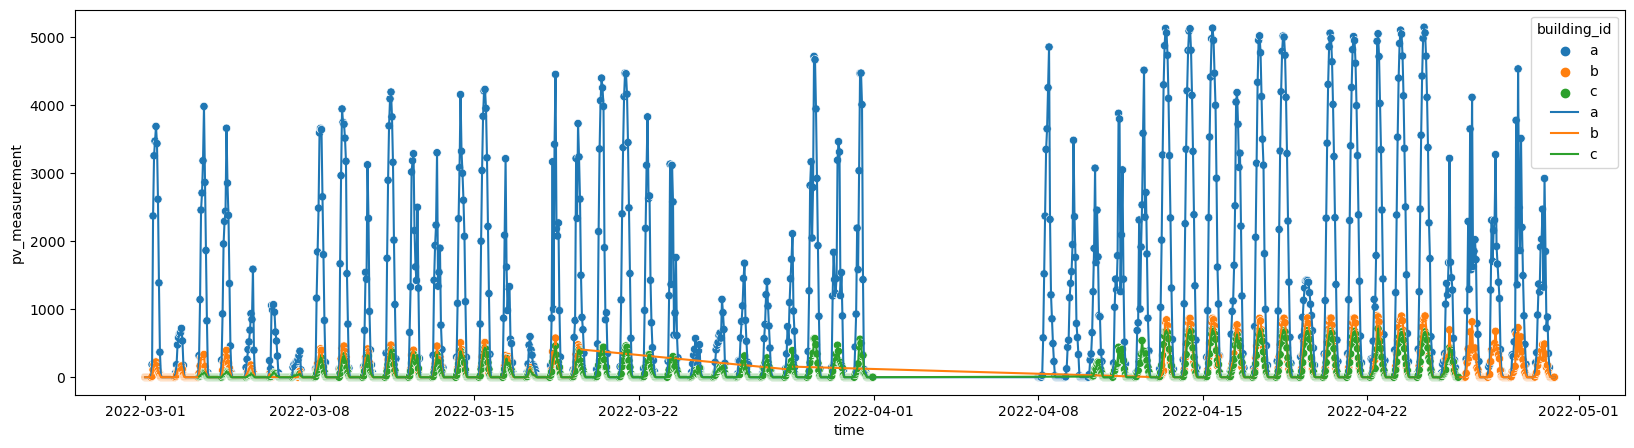

In [3238]:
date_idx = Xy.date_forecast.between('2022-03-01', '2022-04-30')

ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches((20,5))
# ax.set_ylim(0, 500)
sns.scatterplot(data=Xy[date_idx], x='time', y='pv_measurement', hue='building_id', ax = ax)
sns.lineplot(data=Xy[date_idx], x='time', y='pv_measurement', hue='building_id', ax = ax)

In [3239]:
Xy['fresh_snow_24h:cm'].value_counts(dropna=False)

fresh_snow_24h:cm
0.000000     73590
0.300000       159
0.050000       157
0.200000       151
0.075000       122
             ...  
14.525000        1
14.924999        1
14.974999        1
14.575000        1
4.975000         1
Name: count, Length: 492, dtype: int64

In [3240]:
Xy_test[Xy_test['sun_elevation:d'] < 1].groupby('building_id')['pv_measurement'].mean()

building_id
a    2.478584
b    0.186560
c    0.305382
Name: pv_measurement, dtype: float64

In [3241]:
'2022-11-25 16:22:30'
'2023-03-28 01:22:30'


'2023-03-28 01:22:30'

In [3242]:
Xy.columns

Index(['building_id', 'time', 'date_forecast', 'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx',
       'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
       'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx',
       'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
       'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms',

/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

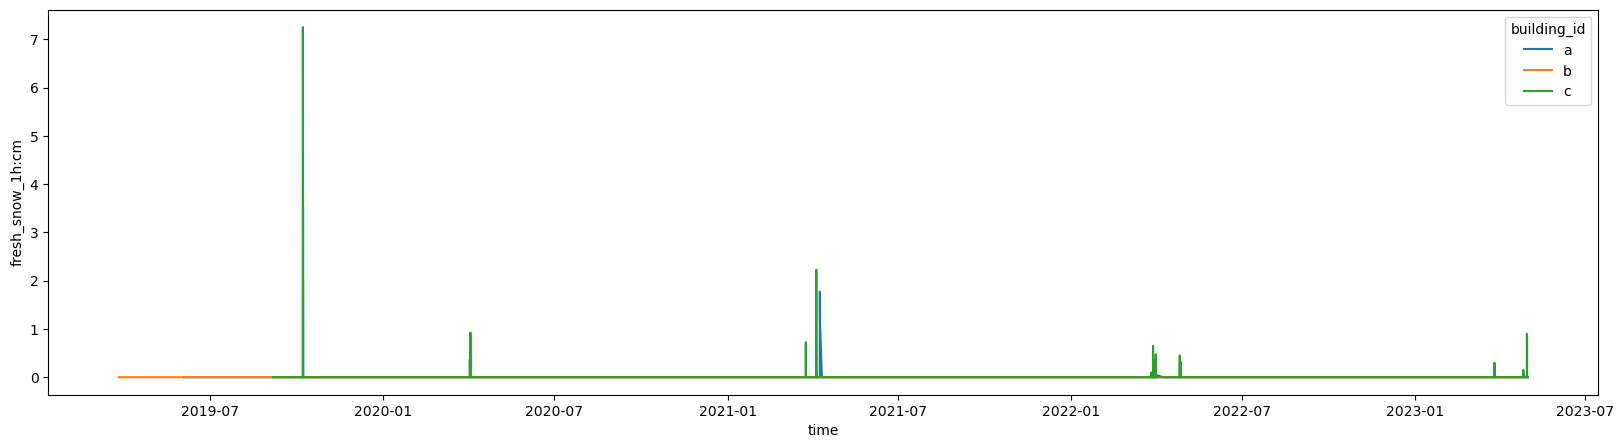

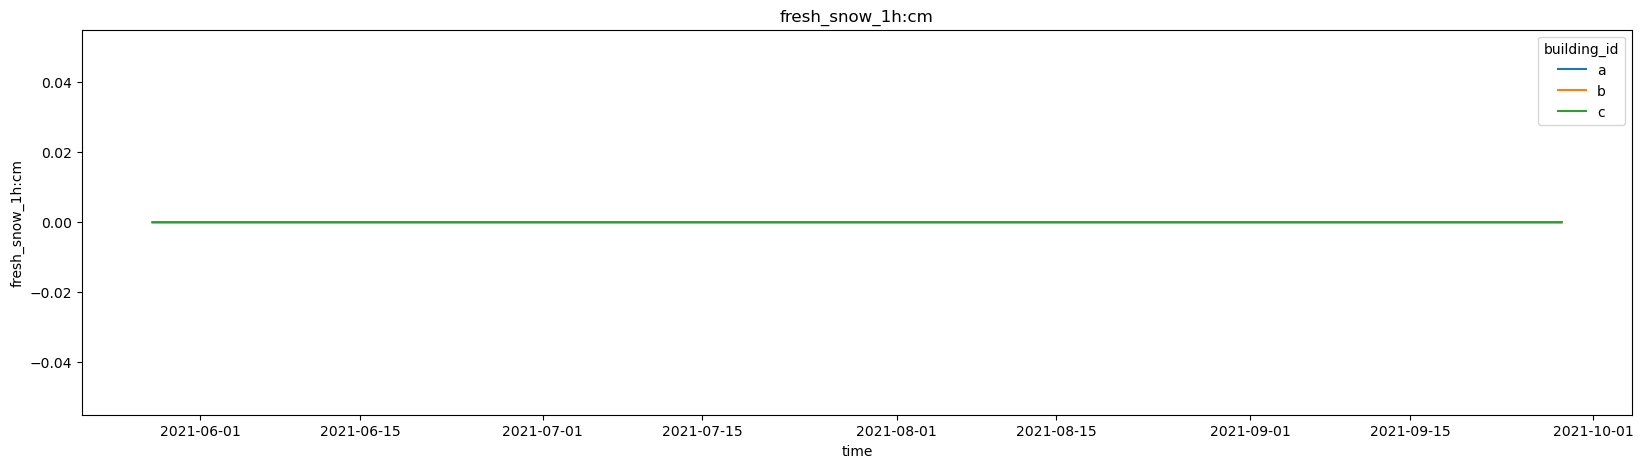

/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

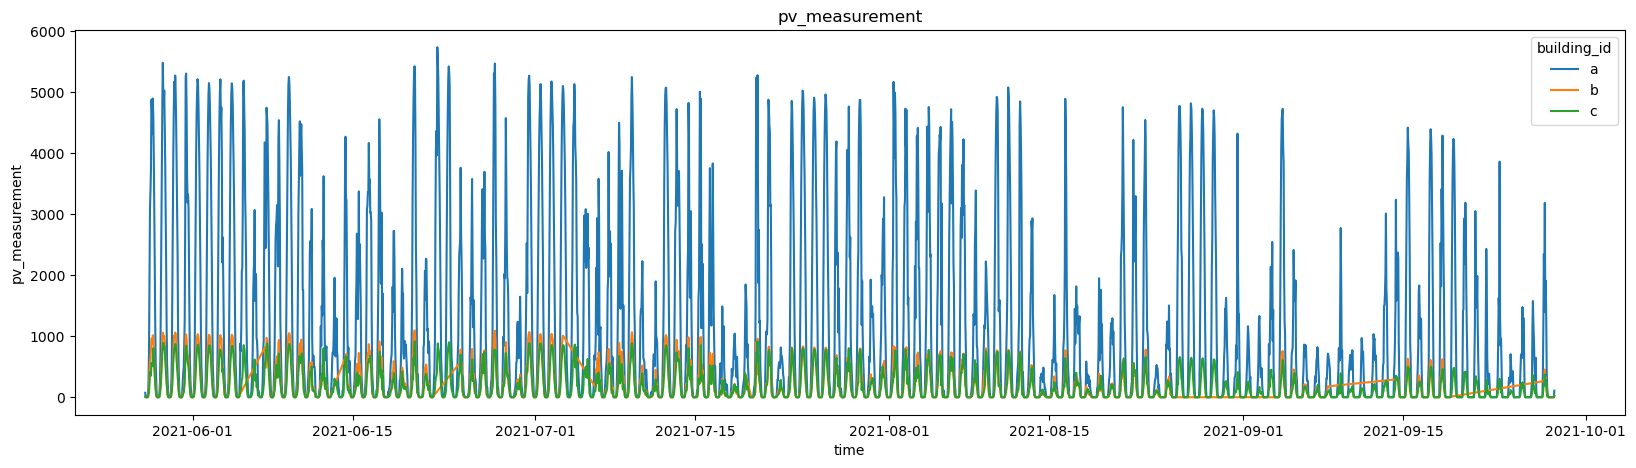

/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

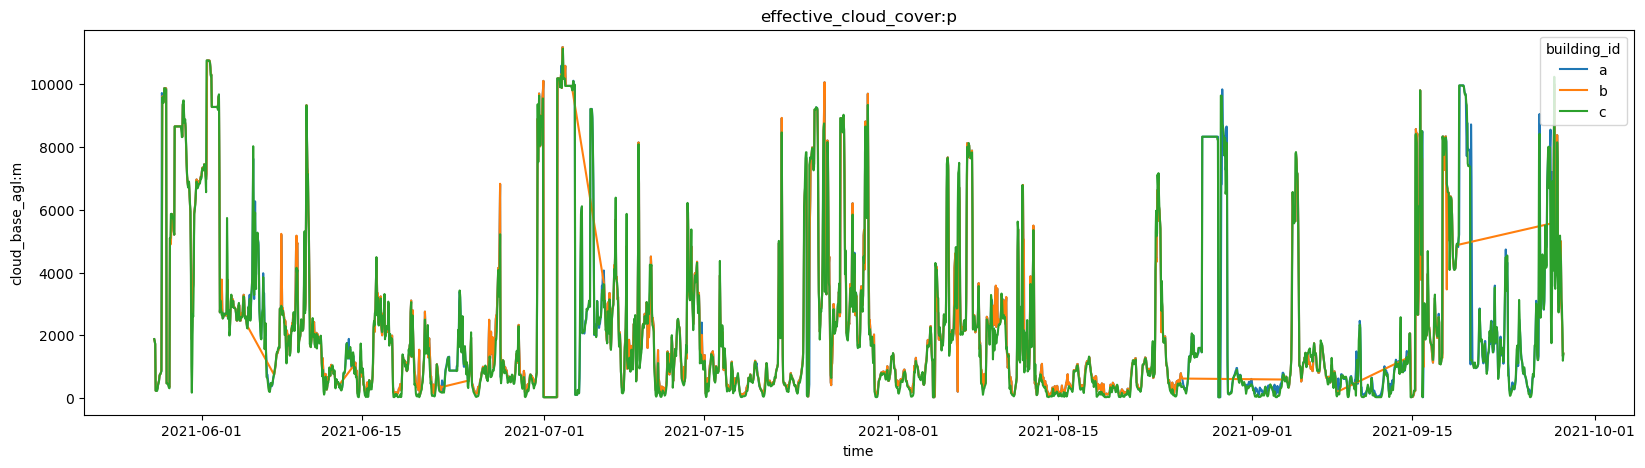

/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

<Axes: xlabel='time', ylabel='pv_measurement'>

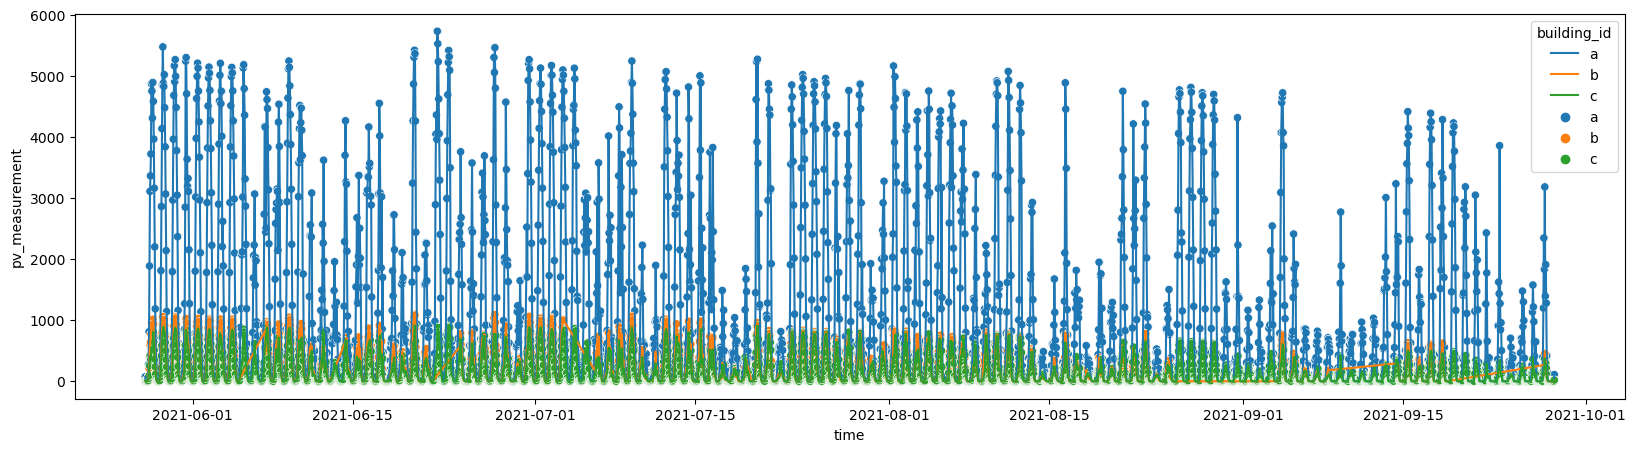

In [3243]:
date_idx_full = (Xy['month'].between(4, 10) | ((Xy['month'] == 3) & (Xy['date_forecast'].dt.day > 23))) #& Xy['date_forecast'].between('2022-01-01','2023-07-15') 
date_idx = Xy['date_forecast'].between('2021-05-27 20:22:30', '2021-09-28 06:22:30')
plt.figure(figsize=(20,5))
sns.lineplot(data=Xy[date_idx_full], x='time', y='fresh_snow_1h:cm', hue='building_id')

plt.figure(figsize=(20,5))
sns.lineplot(data=Xy[date_idx], x='time', y='fresh_snow_1h:cm', hue='building_id')
plt.title('fresh_snow_1h:cm')
plt.show()

plt.figure(figsize=(20,5))
sns.lineplot(data=Xy[date_idx], x='time', y='pv_measurement', hue='building_id')
plt.title('pv_measurement')
plt.show()

plt.figure(figsize=(20,5))
sns.lineplot(data=Xy[date_idx], x='time', y='cloud_base_agl:m', hue='building_id')
plt.title('effective_cloud_cover:p')
plt.show()

plt.figure(figsize=(20,5))
sns.lineplot(data=Xy[date_idx], x='time', y='pv_measurement', hue='building_id')
sns.scatterplot(data=Xy[date_idx], x='time', y='pv_measurement', hue='building_id')




In [3244]:
build_idx = Xy['building_id'] == 'c'
Xy[date_idx & build_idx][['date_forecast', 'pv_measurement', 'sun_elevation:d','building_id','effective_cloud_cover:p','fresh_snow_24h:cm']].head(100)


,date_forecast,pv_measurement,sun_elevation:d,building_id,effective_cloud_cover:p,fresh_snow_24h:cm
70392,2021-05-27 20:22:30,9.8,1.268250,c,2.350000,0.0
70393,2021-05-27 21:22:30,0.0,-2.383000,c,5.325000,0.0
70394,2021-05-27 22:22:30,0.0,-4.598500,c,2.450000,0.0
70395,2021-05-27 23:22:30,0.0,-5.222000,c,0.300000,0.0
70396,2021-05-28 00:22:30,0.0,-4.163750,c,1.100000,0.0
70397,2021-05-28 01:22:30,0.0,-1.690000,c,7.075000,0.0
70398,2021-05-28 02:22:30,9.8,2.183000,c,21.475000,0.0
70399,2021-05-28 03:22:30,49.0,7.209500,c,33.599998,0.0
70400,2021-05-28 04:22:30,88.2,13.106250,c,35.125000,0.0
70401,2021-05-28 05:22:30,254.8,19.567501,c,26.875000,0.0


# Preprocessing

In [3245]:
# Class to scale y
class Y_Scaler_MaxAbs_per_building:
    def __init__(self):
        self.max_per_building = {}

    def fit(self, y, cat):
        assert type(y) == pd.Series
        assert type(cat) == pd.Series

        y_bid = pd.concat([y, cat], axis=1)
        y_bid.columns = ['y', 'cat']

        self.max_per_building = y_bid.groupby('cat')['y'].max().to_dict()
        return self

    def transform(self, y, cat):
        assert type(y) == pd.Series
        assert type(cat) == pd.Series

        y_bid = pd.concat([y, cat], axis=1)
        y_bid.columns = ['y', 'cat']

        y = y_bid.apply(
            lambda row: row['y'] / self.max_per_building[row['cat']], axis=1)
        return y

    def fit_transform(self, y, cat):
        self.fit(y, cat)
        return self.transform(y, cat)

    def inverse_transform(self, y, cat):
        assert type(y) == pd.Series
        assert type(cat) == pd.Series

        y_bid = pd.concat([y, cat], axis=1)
        y_bid.columns = ['y', 'cat']

        y = y_bid.apply(
            lambda row: row['y'] * self.max_per_building[row['cat']], axis=1)
        return y

In [3246]:
# Class to scale y
class Y_Scaler_ClearSky_normalize:
    def __init__(self):
        self.max_per_building = {}

    def fit(self):
        pass

    def transform(self, y, feature):
        assert type(y) == pd.Series
        assert type(feature) == pd.Series

        y_bid = pd.concat([y, feature], axis=1)
        y_bid.columns = ['y', 'feature']

        y.loc[feature > 1] = (y.loc[feature > 1] / feature.loc[feature > 1])

        return y * 1000

    def fit_transform(self, y, feature):
        return self.transform(y, feature)

    def inverse_transform(self, y, feature):
        assert type(y) == pd.Series
        assert type(feature) == pd.Series

        y_bid = pd.concat([y, feature], axis=1)
        y_bid.columns = ['y', 'feature']

        y.loc[feature > 1] = (y.loc[feature > 1] * feature.loc[feature > 1])

        return y / 1000


# Preparing X and y

In [3247]:
# drop empty pv_measurement
Xy = Xy.dropna(subset=['pv_measurement'])

test_idx = Xy['date_forecast'].between('2021/05/01','2021/07/01') 

Xy_train = Xy # not really clean but otherwise we do not have enough summers in the training data
#Xy_train = Xy[~test_idx].reset_index(drop=True)
Xy_test = Xy[test_idx].reset_index(drop=True)

display(Xy_train.isEstimated.value_counts())


# shuffle data
# Xy_train = Xy_train.sample(frac=1, random_state=42).reset_index(drop=True)

# Use only Summer Data
Xy_train = Xy_train[Xy_train['month'].between(4,7)].reset_index(drop=True)

# Use only high sun_elevation data
Xy_train = Xy_train[Xy_train['sun_elevation:d'] >= -2].reset_index(drop=True)

# create custom split
val_idx = Xy_train['date_forecast'].between('2020/05/01', '2020/07/01') - 1
ps = PredefinedSplit(test_fold=val_idx)

# Remove data where sun_elevation is below -5
#Xy_train = Xy_train[Xy_train['sun_elevation:d'] >= -10].reset_index(drop=True)


X = Xy.drop(columns=['pv_measurement'])
y = Xy['pv_measurement']

X_train = Xy_train.drop(columns=['pv_measurement'])
y_train = Xy_train['pv_measurement']

X_test = Xy_test.drop(columns=['pv_measurement'])
y_test = Xy_test['pv_measurement']


isEstimated
0.0    68071
1.0    10520
Name: count, dtype: int64

In [3248]:
# Scale y
y_scaler_MaxAbs = Y_Scaler_MaxAbs_per_building()
y_train = y_scaler_MaxAbs.fit_transform(y_train, X_train['building_id'])

y_scaler_MaxAbs_y = Y_Scaler_MaxAbs_per_building()
y = y_scaler_MaxAbs_y.fit_transform(y, X['building_id'])


# y_o = y_scaler.fit_transform(y_o, X_o['building_id'])
# y_e = y_scaler.transform(y_e, X_e['building_id']) # no fit_transform because we use y_e as test data

#sns.lineplot(data=y_train, label='y_train', hue=X_train['building_id'])


# Scale whole y
# full_scaler = RobustScaler()
# y_o = full_scaler.fit_transform(y_o.values.reshape(-1, 1)).flatten()
# y_e = full_scaler.transform(y_e.values.reshape(-1, 1)).flatten() # no fit_transform because we use y_e as test data


# y_scaler_clear_sky = Y_Scaler_ClearSky_normalize()
# y_train = y_scaler_clear_sky.fit_transform(y_train, X_train['clear_sky_rad:W'])

# y_scaler_clear_sky_y = Y_Scaler_ClearSky_normalize()
# y = y_scaler_clear_sky_y.fit_transform(y, X['clear_sky_rad:W'])


In [3249]:
print(f"X.shape: {Xy_train.shape}")
print(f"X.shape: {Xy_test.shape}")


X.shape: (19735, 79)
X.shape: (4226, 79)


In [3250]:
test_idx = X_train['date_forecast'].between('2021/05/01', '2021/07/01') # needs to be done before dropping date_forecast

In [3251]:
# drop irrelevant columns
drop_cols = [
    'time', 
    'date_forecast', 
    'snow_density:kgm3',
    'date_calc', 
    'monthYear', 
    'dayMonthYear',
    'elevation:m',]

drop2 = ['clear_sky_energy_1h:J',
         'direct_rad_1h:J',
         'fresh_snow_24h:cm',
         'fresh_snow_1h:cm',
         'fresh_snow_12h:cm',
         'diffuse_rad_1h:J',
         'dew_point_2m:K',
         'dew_or_rime:idx',
         'precip_5min:mm',
         'fresh_snow_6h:cm',
         'prob_rime:p',
         'ceiling_height_agl:m',
         'rain_water:kgm2',
         'sfc_pressure:hPa',
         'snow_depth:cm',
         'snow_drift:idx',
         'snow_melt_10min:mm',
         'snow_water:kgm2',
         'pressure_50m:hPa',
         'wind_speed_w_1000hPa:ms',
         'pressure_100m:hPa',
         'fresh_snow_3h:cm']



drop_cols = drop_cols  # + drop2



print(drop_cols)
# ignore if column does not exist
X_train = X_train.drop(drop_cols, axis=1, errors='ignore')
X_test = X_test.drop(drop_cols, axis=1, errors='ignore')
# ignore if column does not exist
X = X.drop(drop_cols, axis=1, errors='ignore')
X_submission = X_submission.drop(drop_cols, axis=1, errors='ignore')


['time', 'date_forecast', 'snow_density:kgm3', 'date_calc', 'monthYear', 'dayMonthYear', 'elevation:m']


In [3252]:
# imp_features = [
#     'building_id',
#     # 'clear_sky_rad:W',
#      'cloud_base_agl:m',
#     # 'diffuse_rad:W',
#     'effective_cloud_cover:p',
#     # 'is_in_shadow:idx',
#     # 'precip_5min:mm',
#     # 'sun_azimuth:d',
#     # 'sun_elevation:d',
#     # 't_1000hPa:K',
#      'total_cloud_cover:p',
#     # 'month',
#     # 'hour',
#     # 'delta_forecast',
#     'GHI',
#     # 'wind_angle_sin',
#     # 'wind_angle_cos',
#      'wind_speed_10m:ms'
# ]

# X_train = X_train[imp_features]
# X_test = X_test[imp_features]
# X_submission = X_submission[imp_features]
# X = X[imp_features]

In [3253]:
# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train.loc[:, X.isna().any()].columns.tolist()

print(f"categorical_features: {categorical_features}")
print(f"impute_features: {impute_features}")


categorical_features: ['building_id']
impute_features: ['delta_forecast', 'GHI_std', 'effective_cloud_cover_5h_mean']


# Building the pipeline

In [3254]:
from sklearn.base import BaseEstimator, TransformerMixin


class StatusSaver(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # append "1," to status file
        with open('status.csv', 'a') as f:
            f.write('1\n')

        return self

    def transform(self, X):
        # Your transformation logic here
        # Return the transformed data
        return X


# create empty txt file
open('status.csv', 'w').close()

In [3255]:


# BayesSearchCV
parameters_bayes = {
    'estimator__n_estimators': Integer(30,500),
    'estimator__max_depth': Integer(6, 14),
    'estimator__learning_rate': Real(0.01, 0.3),
    # 'estimator__subsample': Real(0.5, 1.0),
    # 'estimator__colsample_bytree': Real(0.8, 1.0),
    # 'estimator__colsample_bylevel': Real(0.8, 1.0),
    # 'estimator__colsample_bynode': Real(0.8, 1.0),
    #'estimator__gamma': Real(0, 2),
    # 'estimator__reg_alpha': Real(0, 10),
    # 'estimator__reg_lambda': Real(1, 10),
    # 'estimator__min_child_weight': Integer(1, 10),
    #'estimator__max_delta_step': Integer(0, 5)
}

parameters_grid_xgb = {
     'estimator__n_estimators': [50],
    # 'estimator__max_depth': np.arange(14,3,-1),
    # 'estimator__learning_rate': np.arange(0.4, 0, -0.01),
    # 'estimator__subsample': [0.8, 0.9,1],
    # 'estimator__colsample_bytree': np.arange(0.3, 1, 0.025),
    # 'estimator__colsample_bynode': np.arange(0.3, 1, 0.025),
    # 'estimator__colsample_bylevel': np.arange(0.3, 1, 0.025),
    # 'estimator__gamma': [0, 0.5, 1, 1.5, 2],
    # 'estimator__reg_alpha': np.arange(0, 3, 0.1),
    # 'estimator__reg_lambda': np.arange(0, 10, 0.25),
    # 'estimator__min_child_weight': np.arange(1, 5, 0.25),
    #  'estimator__n_estimators': np.arange(200,9,-10),
}

parameters_grid_lgbm = {
    #'estimator__num_leaves': np.arange(10,121,10),
    # 'estimator__min_data_in_leaf': list(range(3,14)),
     #'estimator__max_depth': list(range(3,14)),
     #'estimator__reg_alpha': np.arange(0, 10, 0.5),
    'estimator__reg_lambda': np.arange(0, 20, 0.25),
}

parameters_grid_catb = {
    'estimator__iterations': [800]#np.arange(500, 2000, 50),
    #'estimator__depth': list(range(3,14)),
     #'estimator__max_depth': list(range(3,14)),
     #'estimator__reg_alpha': np.arange(0, 10, 0.5),
    #'estimator__reg_lambda': np.arange(0, 20, 0.25),
}



In [3256]:
def std_per_sample(y, y_pred):
    return np.std((y - y_pred), axis=0)

def TEST(y,y_pred):
    return y - y_pred

std_scorer = make_scorer(std_per_sample, greater_is_better=False)

scoring = {
    'MAE': 'neg_mean_absolute_error',
    'STD': std_scorer
}



In [3257]:
# set column transformer
columnTransformer = ColumnTransformer(
    transformers=[
        ('imputer', SimpleImputer(strategy='constant'),impute_features),
        ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ],
    remainder='passthrough',  # Dont drop remaining columns
    n_jobs=-1
)

xgb = xgboost.XGBRegressor(
    random_state=42,
    learning_rate=0.1,
    max_depth=7,
    # reg_alpha=2,
    # reg_lambda=5,
    n_estimators=50,
    colsample_bytree=0.5,
    # min_child_weight=2,
)

lgbm = LGBMRegressor(
    num_leaves=31,
    min_data_in_leaf=6,
    max_depth=5,
    random_state=42,
    reg_alpha = 0,
    reg_lambda = 7,
)

catboost = CatBoostRegressor(
    cat_features = ['building_id'],
    iterations=800,
    depth=13,
)

# build the pipeline
pipeline = Pipeline(steps=[
    ('columnTransformer', columnTransformer),
    ('statusSaver', StatusSaver()),
    ('estimator', xgb)
])



# create bayesian search estimator
m1_BayesCV = BayesSearchCV(
    pipeline, parameters_bayes, scoring='neg_mean_absolute_error', cv=6, error_score='raise',n_points=6, n_jobs=-1, verbose=2, n_iter=1080, random_state=42)


m1_GridCV = GridSearchCV(
    pipeline, parameters_grid_xgb, scoring=scoring, cv=ps, error_score='raise', n_jobs=-1, verbose=2, refit='MAE')

# switch between BayesCV and GridCV
m1_CV = m1_GridCV

# fit the estimator on the data
#m1_CV.fit(X_o, y_o)
m1_CV.fit(X_train, y_train)

# get best model 
m1 = m1_CV.best_estimator_


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] END .........................estimator__n_estimators=50; total time=   0.5s


In [3258]:
# print the scores
# print('Best score:', m1_CV.best_score_)
print('Best parameters:', m1_CV.best_params_)

Best parameters: {'estimator__n_estimators': 50}


In [3259]:
#sns.lineplot(m1_CV.cv_results_['mean_test_score'])

In [3260]:
m1_CV.param_grid

{'estimator__n_estimators': [50]}

/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option

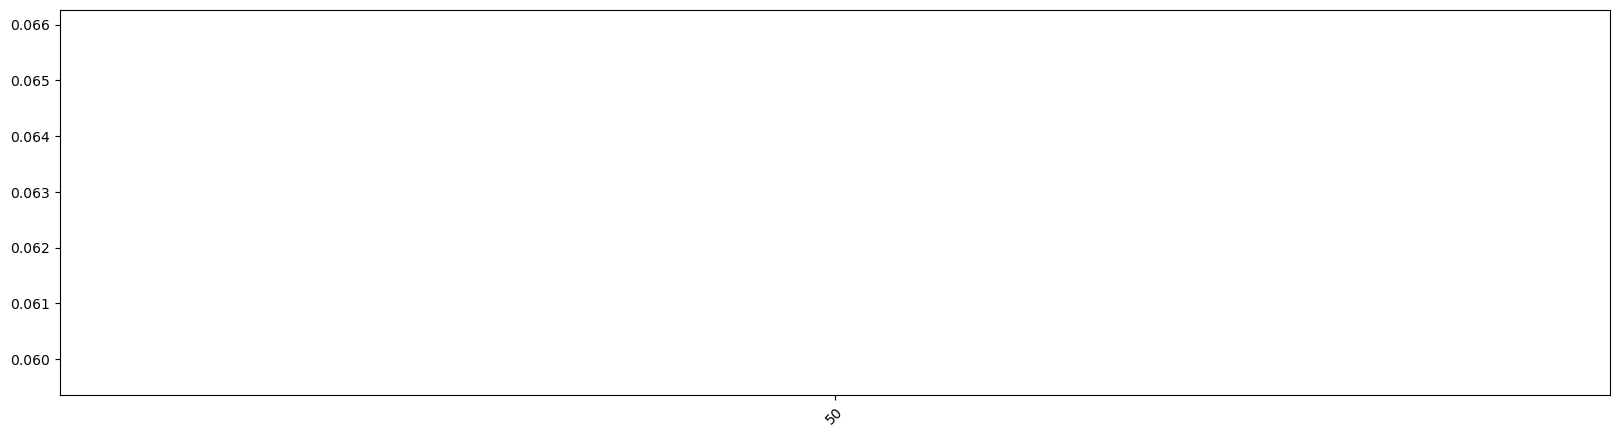

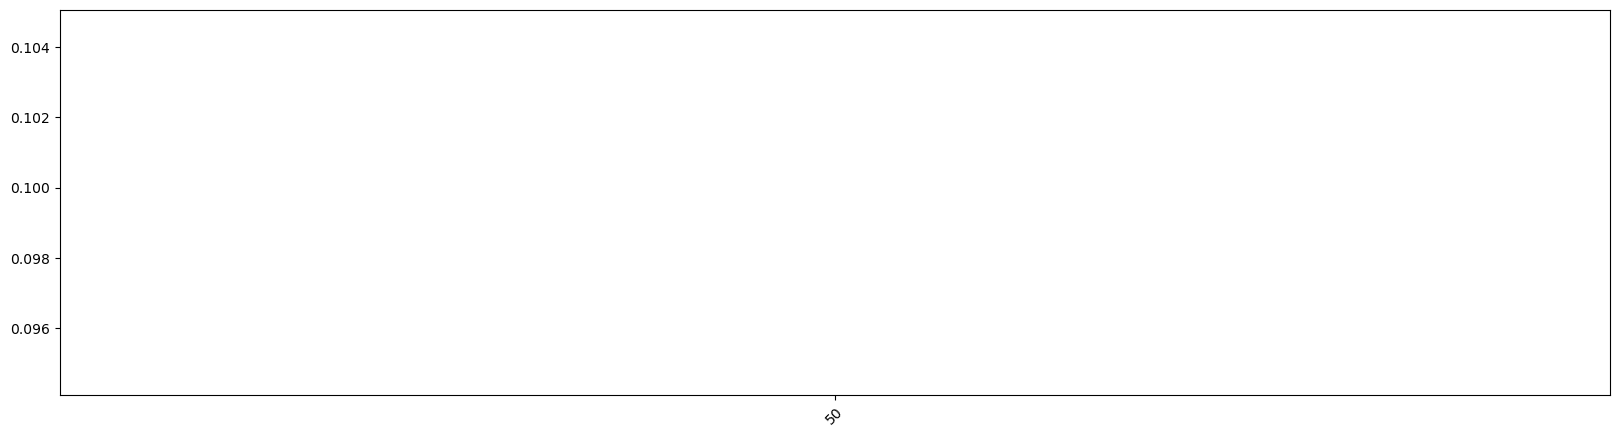

In [3261]:

for key, values in m1_CV.param_grid.items():
    pass

plt.figure(figsize=(20, 5))


sns.lineplot(y=m1_CV.cv_results_['mean_test_MAE']*-1, x=list(map(str, values)))
plt.xticks(rotation=45);


plt.figure(figsize=(20, 5))
sns.lineplot(y=m1_CV.cv_results_['mean_test_STD']*-1, x=list(map(str, values)))
plt.xticks(rotation=45);


In [3262]:
m1_CV.cv_results_['mean_test_MAE']*-1

array([0.06281286])

<Axes: xlabel='feature'>

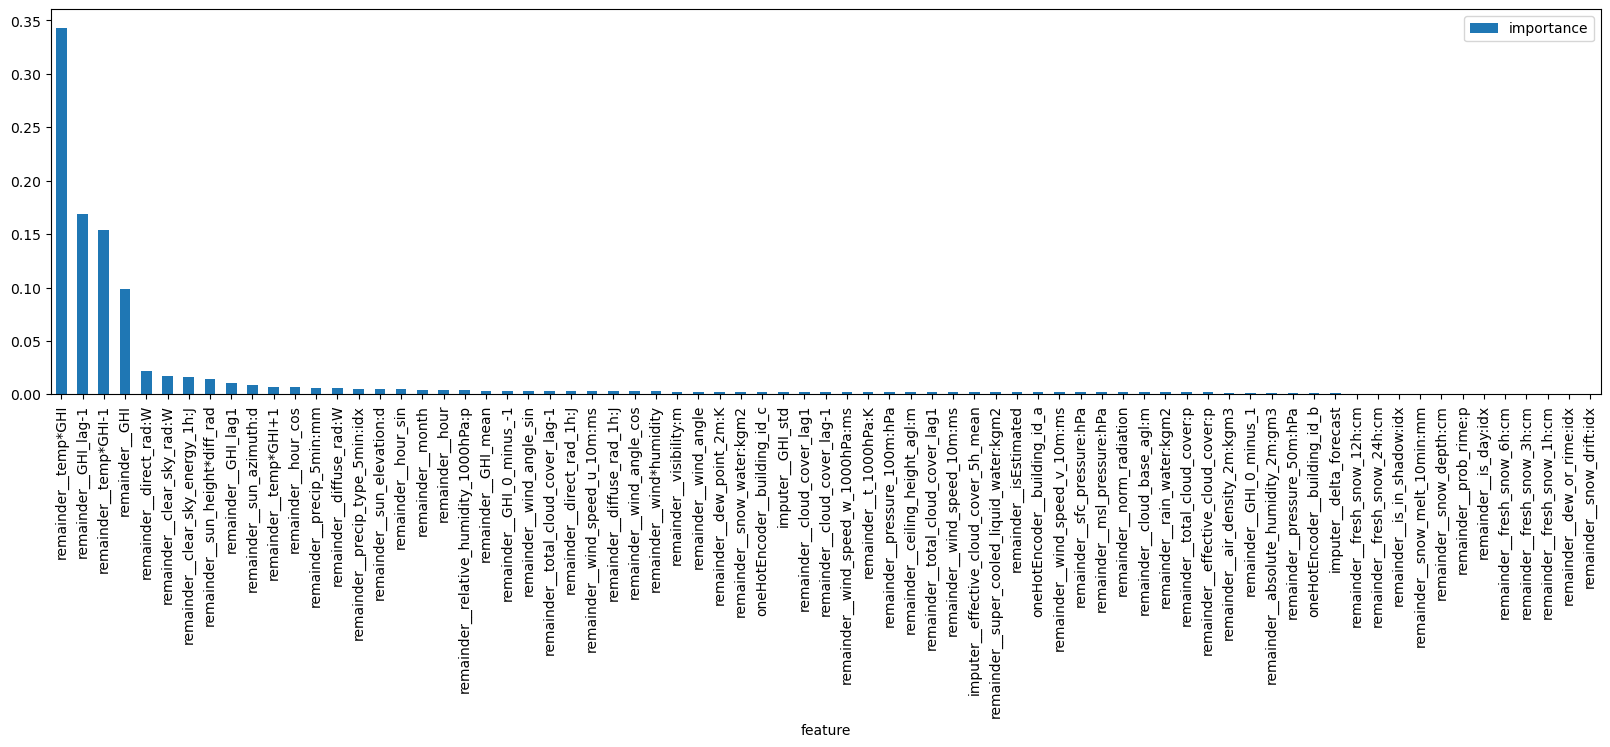

In [3263]:
#f_names = m1[:-1].get_feature_names_in()
f_names = X_train.columns.tolist()
f_names = m1.steps[-3][1].get_feature_names_out()
f_importances = m1.steps[-1][1].feature_importances_

f_importances_df = pd.DataFrame({'feature': f_names, 'importance': f_importances})

f_importances_df = f_importances_df.sort_values(by='importance', ascending=False)

f_importances_df.plot.bar(x='feature', y='importance', figsize=(20, 5))


In [3264]:
Xy.head(
)

,building_id,time,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,isEstimated,date_calc,pv_measurement,monthYear,dayMonthYear,month,hour,delta_forecast,GHI,wind_angle,norm_radiation,GHI_lag-1,GHI_lag1,wind_angle_sin,wind_angle_cos,hour_sin,hour_cos,GHI_mean,GHI_std,GHI_0_minus_-1,GHI_0_minus_1,temp*GHI,wind*humidity,sun_height*diff_rad,temp*GHI-1,temp*GHI+1,cloud_cover_lag-1,cloud_cover_lag1,total_cloud_cover_lag-1,total_cloud_cover_lag1,effective_cloud_cover_5h_mean
0,a,2019-06-03 01:00:00,2019-06-03 01:22:30,8.425,1.2180,1283.425049,208.649994,0.750000,1283.425049,0.0,281.674988,0.300000,526.775024,0.000000,0.000000,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.25,1.0,1004.025024,0.0,0.0,991.500000,997.449951,0.0,0.125,73.875000,1003.449951,NaN,0.0,0.0,0.0,0.55,28.630251,-0.82250,0.0,286.750000,100.000000,2321.850098,2.725,-2.60,0.875,0.0,0.0,NaT,0.00,2019-06,2019-06-03,6.0,1.0,NaN,0.300000,-1.246164,0.400000,12.125000,0.000000,-0.947768,0.318960,0.258819,0.965926,195.273972,187.936325,-11.825000,0.300000,86.025002,201.309372,-0.246750,3473.206299,0.000000,84.875000,100.000000,99.224998,100.000000,NaN
1,a,2019-06-03 02:00:00,2019-06-03 02:22:30,8.950,1.2180,1003.500000,32468.150391,23.100000,1003.500000,0.0,282.500000,11.975000,22068.949219,0.150000,282.975006,84.875000,6.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,1003.099976,0.0,0.0,990.550049,996.500000,0.0,0.100,79.925003,1002.500000,NaN,0.0,0.0,0.0,0.25,41.997501,3.05125,0.0,286.450012,99.224998,11634.799805,2.550,-2.35,0.925,0.0,0.0,NaT,19.36,2019-06,2019-06-03,6.0,2.0,NaN,12.125000,-1.195805,0.524892,51.424999,0.300000,-0.930511,0.366265,0.500000,0.866025,195.273972,187.936325,-39.299999,11.825000,3473.206299,203.808762,36.538719,14731.976562,86.025002,65.025002,100.000000,94.800003,100.000000,NaN
2,a,2019-06-03 03:00:00,2019-06-03 03:22:30,9.250,1.2165,809.375000,179499.078125,84.375000,809.375000,0.0,283.049988,45.125000,102788.046875,6.300000,11627.549805,65.025002,6.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,1002.349976,0.0,0.0,989.750000,995.700012,0.0,0.000,82.849998,1001.674988,NaN,0.0,0.0,0.0,0.10,55.041748,8.07100,0.0,286.475006,94.800003,29848.199219,2.300,-2.20,0.800,0.0,0.0,NaT,251.02,2019-06,2019-06-03,6.0,3.0,NaN,51.424999,-1.222025,0.609481,133.250000,12.125000,-0.939793,0.341743,0.707107,0.707107,195.273972,187.936325,-81.824997,39.299999,14731.976562,190.554993,364.203888,38219.433594,3473.206299,77.550003,84.875000,95.099998,99.224998,412.500000
3,a,2019-06-03 04:00:00,2019-06-03 04:22:30,9.525,1.2130,757.775024,478117.812500,186.649994,757.775024,0.0,283.524994,89.525002,242438.000000,43.724998,90073.375000,77.550003,6.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,1001.825012,0.0,0.0,989.250000,995.200012,0.0,0.000,82.275002,1001.174988,NaN,0.0,0.0,0.0,0.00,67.898003,13.95650,0.0,286.825012,95.099998,35980.148438,2.325,-2.20,0.750,0.0,0.0,NaT,263.78,2019-06,2019-06-03,6.0,4.0,NaN,133.250000,-1.242243,0.713903,192.100006,51.424999,-0.946510,0.322674,0.866025,0.500000,195.273972,187.936325,-58.850006,81.824997,38219.433594,191.289383,1249.455688,55195.136719,14731.976562,85.050003,65.025002,97.150002,94.800003,409.250000
4,a,2019-06-03 05:00:00,2019-06-03 05:22:30,9.700,1.2075,705.650024,892667.875000,311.525024,705.650024,0.0,283.799988,139.000000,41138

In [3265]:
if type(m1_CV) == BayesSearchCV:
    _ = plot_objective(m1_CV.optimizer_results_[0])
    plt.show()

# Test model on test data

In [3266]:
# predict on estimated data
m1.fit(X_train[~test_idx].reset_index(drop=True), y_train[~test_idx].reset_index(drop=True))
m1_pred = pd.Series(m1.predict(X_test))
#m1_pred = pd.Series(full_scaler.inverse_transform(m1_pred.values.reshape(-1, 1)).flatten())
#m1_pred = y_scaler.inverse_transform(m1_pred, X_e['building_id'])
# m1_pred = y_scaler_clear_sky.inverse_transform(m1_pred, X_test['clear_sky_rad:W'])
# m1_pred = y_scaler_clear_sky_y.inverse_transform(m1_pred, X_test['clear_sky_rad:W'])
m1_pred = y_scaler_MaxAbs_y.inverse_transform(m1_pred, X_test['building_id'])
m1_pred = m1_pred.clip(lower=0) # zero m1 pred
Xy_test['m1_pred'] = m1_pred

# calculate abs diff
Xy_test['abs_diff'] = np.abs(Xy_test['pv_measurement'] - Xy_test['m1_pred'])
Xy_test['diff'] = (Xy_test['pv_measurement'] - Xy_test['m1_pred'])

# calculate mae
mae = Xy_test['abs_diff'].mean()
print('MAE:', mae)


MAE: 152.25401323226401


In [3267]:

m1_pred

0        22.305881
1        22.924016
2        24.030603
3        36.678925
4       142.045664
           ...    
4221     58.354719
4222     17.636873
4223      4.537735
4224      4.537735
4225      4.537735
Length: 4226, dtype: float64

In [3268]:
feature_name = 'sun_elevation:d'


Xy_test['m1_pred'] = m1_pred

# calculate abs diff
Xy_test['abs_diff'] = np.abs(Xy_test['pv_measurement'] - Xy_test['m1_pred'])
Xy_test['diff'] = (Xy_test['pv_measurement'] - Xy_test['m1_pred'])

Xy_test['m1_pred_transformed'] = Xy_test.apply(lambda row: 0 if row['sun_elevation:d'] < 1 else row['m1_pred'], axis=1)

# calculate abs diff
Xy_test['abs_diff_transformed'] = np.abs(Xy_test['pv_measurement'] - Xy_test['m1_pred_transformed'])
Xy_test['diff_transformed'] = (Xy_test['pv_measurement'] - Xy_test['m1_pred_transformed'])

# calculate mae
mae = Xy_test['abs_diff'].mean()
print('MAE:', mae)

# calculate mae
mae = Xy_test['abs_diff_transformed'].mean()
print('MAE tranformed:', mae)

MAE: 152.25401323226401
MAE tranformed: 150.08196927589864


/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as

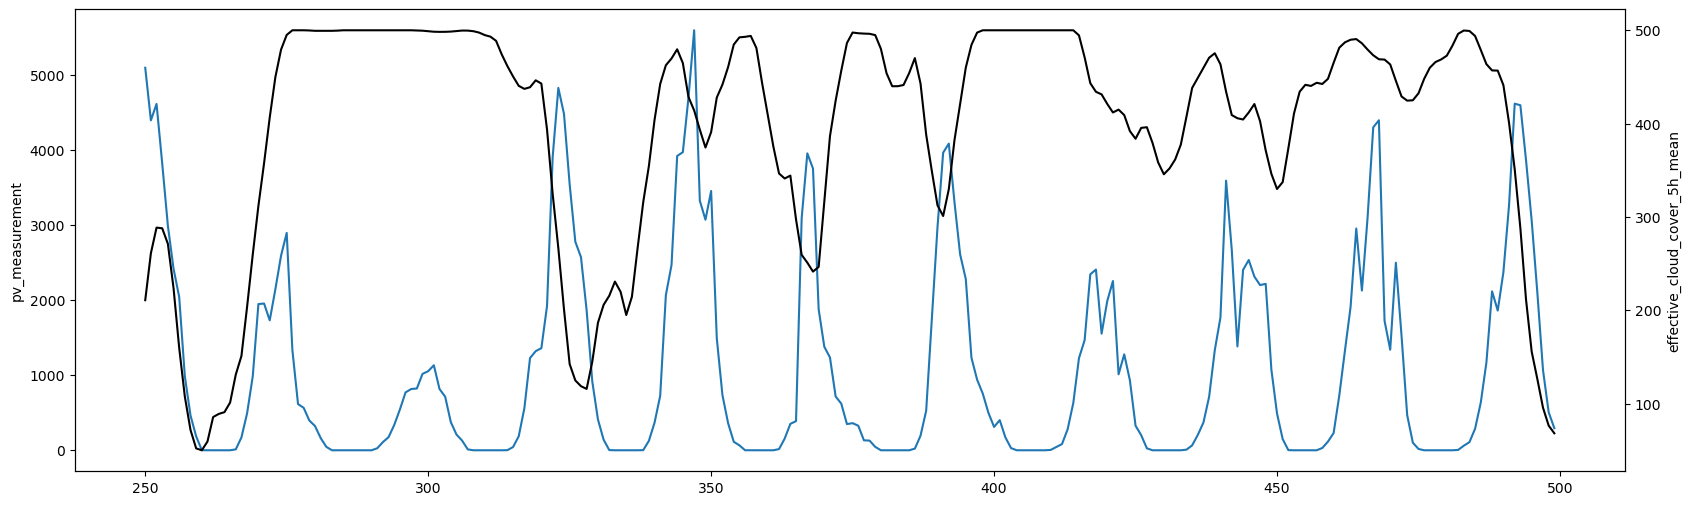

/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

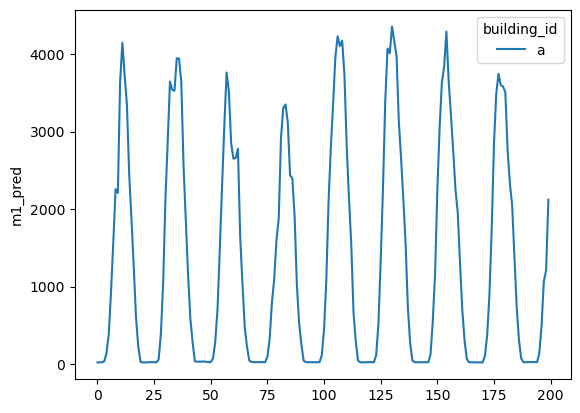

/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

<Axes: ylabel='total_cloud_cover:p'>

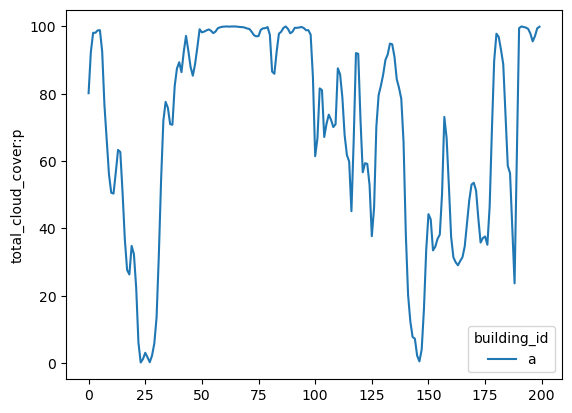

In [3269]:
plt.figure(figsize=(20, 6))

index_from = 250
index_to = 500

ax_1 = sns.lineplot(data=Xy_test[index_from:index_to], x=Xy_test.index[index_from:index_to], y='pv_measurement')
# sns.lineplot(data=Xy_test[index_from:index_to], x=Xy_test.index[index_from:index_to], y='m1_pred',ax=ax_1)
ax_2 = ax_1.twinx()
# sns.lineplot(data=Xy_test[index_from:index_to], x=Xy_test.index[index_from:index_to], y='effective_cloud_cover:p', color='red', ax=ax_2)
# sns.lineplot(data=Xy_test[index_from:index_to], x=Xy_test.index[index_from:index_to], y='cloud_cover_lag-1', color='black', ax=ax_2)
# sns.lineplot(data=Xy_test[index_from:index_to], x=Xy_test.index[index_from:index_to], y='GHI', color='red', ax=ax_2)
Xy_test['cloud*ghi'] = Xy_test['GHI'] * Xy_test['effective_cloud_cover:p']
sns.lineplot(data=Xy_test[index_from:index_to], x=Xy_test.index[index_from:index_to], y='effective_cloud_cover_5h_mean', color='black', ax=ax_2)
# sns.lineplot(data=Xy_test[index_from:index_to], x=Xy_test.index[index_from:index_to], y='diffuse_rad:W', color='green', ax=ax_2)


plt.show()
sns.lineplot(data=Xy_test[:200], x=Xy_test.index[:200], y='m1_pred', hue='building_id')
plt.show()
sns.lineplot(data=Xy_test[:200], x=Xy_test.index[:200], y='total_cloud_cover:p', hue='building_id')



<Axes: >

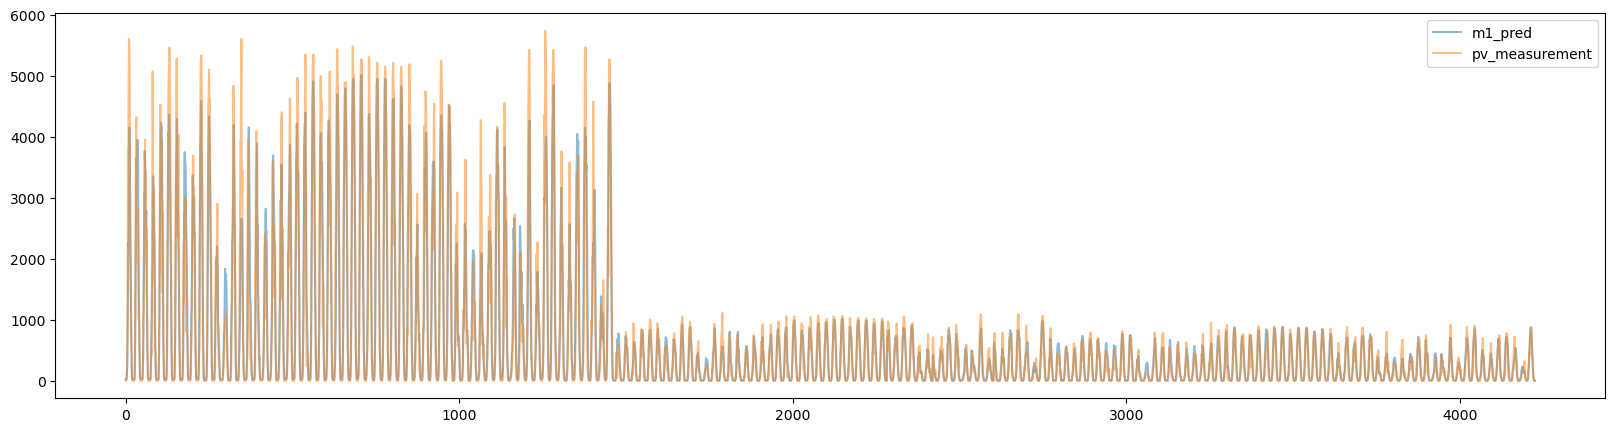

In [3270]:
Xy_test[['m1_pred','pv_measurement']].plot(figsize=(20,5), alpha=0.5)

/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

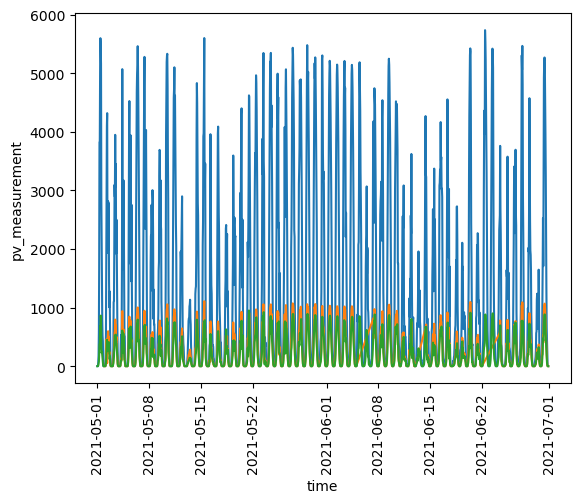

In [3271]:
sns.lineplot(data=Xy_test, x='time', y='pv_measurement', hue='building_id', legend=False)
plt.xticks(rotation=90);


/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

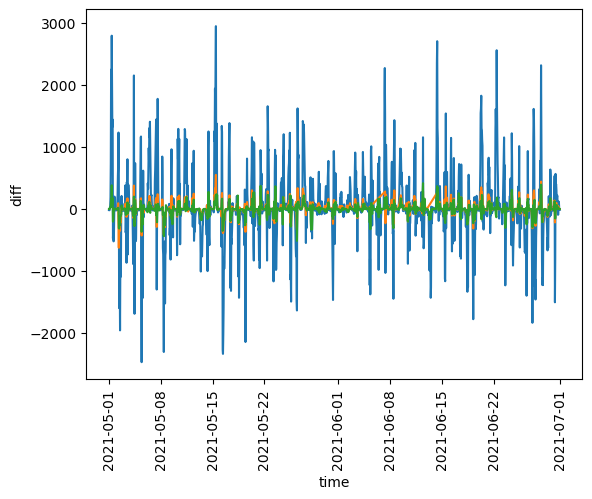

In [3272]:
sns.lineplot(data=Xy_test, x='time', y='diff', hue='building_id', legend=False)
plt.xticks(rotation=90);


In [3278]:
# Creating the submission file
#m1.fit(X, y)

# prepare dataframes
y_test_pred = pd.Series(m1.predict(X_submission))
# y_test_pred = pd.Series(full_scaler.inverse_transform(
#     y_test_pred.values.reshape(-1, 1)).flatten())
#y_test_pred = y_scaler.inverse_transform(y_test_pred, X_t['building_id']).copy()
# y_test_pred = y_scaler_clear_sky_y.inverse_transform(y_test_pred, X_submission['GHI']).copy()
y_test_pred = y_scaler_MaxAbs_y.inverse_transform(y_test_pred, X_submission['building_id']).copy()

# remove negative predictions
y_test_pred = y_test_pred.clip(lower=0)

Xy_pred_submission = pd.concat([X_submission, y_test_pred.rename('prediction')], axis=1)
Xy_pred_submission['prediction'] = Xy_pred_submission.apply(lambda row: 0 if row['sun_elevation:d'] < 1 else row['prediction'], axis=1)

# rename columns etc.
y_test_pred = y_test_pred.reset_index().rename(
    columns={0: 'prediction', 'index': 'id'})

# save submission file
Xy_pred_submission['prediction'].to_csv(
    'xgboost.csv', index=True, header=True)

In [3274]:
# rename columns etc.
y_test_pred = y_test_pred.reset_index().rename(
    columns={0: 'prediction', 'index': 'id'})

y_test_pred

,id,id,prediction
0,0,0,325.077943
1,1,1,22.658544
2,2,2,22.658544
3,3,3,51.541299
4,4,4,315.967858
...,...,...,...
2155,2155,2155,50.379371
2156,2156,2156,28.991108
2157,2157,2157,19.137540
2158,2158,2158,19.137540


In [3275]:
Xy_sub = pd.concat([X_submission, y_test_pred['prediction']], axis=1)

In [3276]:
X['sun_elevation:d'].describe()

count    78591.000000
mean         0.015561
std         23.938982
min        -49.917999
25%        -16.948375
50%          0.044500
75%         16.842875
max         49.943748
Name: sun_elevation:d, dtype: float64

/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

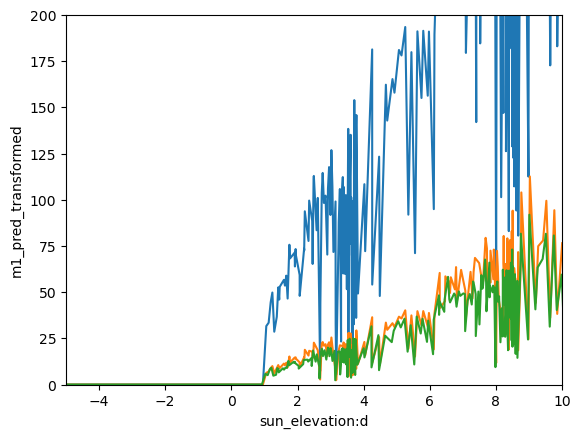

/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

<Axes: xlabel='sun_elevation:d', ylabel='pv_measurement'>

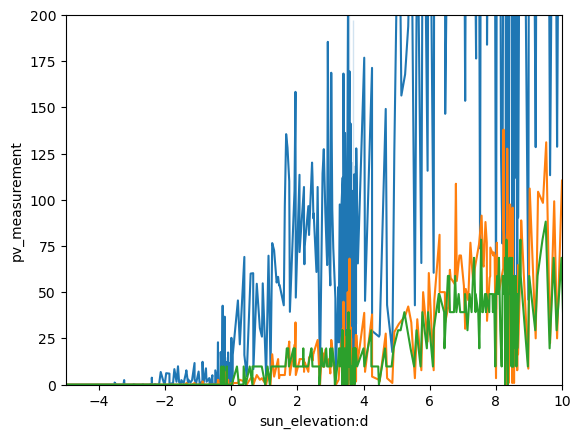

In [3277]:
ax = plt.gca()
plt.ylim(0, 200)
plt.xlim(-5,10)
sns.lineplot(data=Xy_test, x='sun_elevation:d', y='m1_pred_transformed', hue='building_id', legend=False, ax=ax)

plt.show()

ax = plt.gca()
plt.ylim(0, 200)
plt.xlim(-5,10)
# plt.xlim(-20,0)
sns.lineplot(data=Xy_test, x='sun_elevation:d', y='pv_measurement', hue='building_id', legend=False, ax=ax)

#